# 基于Embedding的本地知识问答系统
接下来就举例如何构建一个基于Embedding的本地知识问答系统，简单来说分为三个步骤：

**第一步：准备数据**

收集：准备一个本地知识库，提供需要的文本，如文章、报告、日记、博文、网页、论文等等，这里我们以劳动法为例；

分块：将整篇的文档切分成小的文本片段（Chunk）；

嵌入：将文本片段使用Embedding模型来将文本向量化为多维向量数组；

存储：对于大型数据集，需要将向量数组存储，以便于以后调用。对于小型数据集可以选择临时存储的方式；

**第二步：语义检索**

将用户问题使用Embedding模型来将问题生成Embedding嵌入；

通过向量值之间的相似度检索（如余弦相似度或欧式距离算法），查询与问题最相似的文本片段；

**第三步：文本注入和回答**

将用户问题和查询到的最相似的文本片段（TopK）作为提问消息上下文注入到大模型中；

大模型根据用户问题和注入的少样本提示回答出问题；

以下是原理实现流程图：

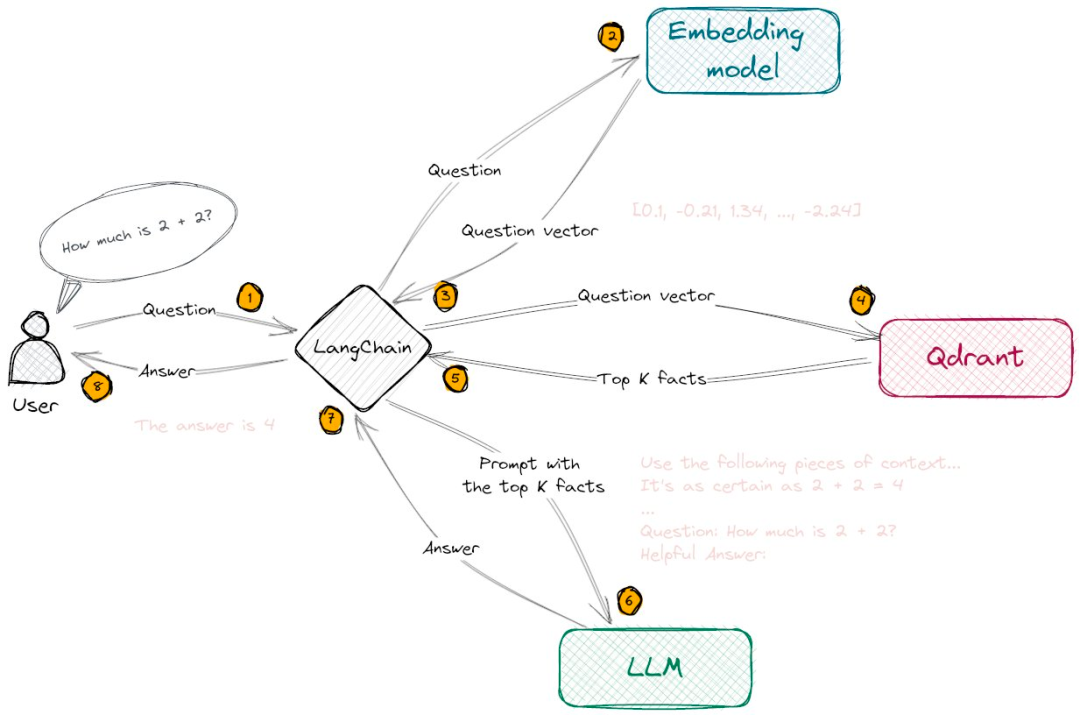

注：这里Qdrant是一个开源的向量数据库

首先，定义模型

In [2]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="qwen:4b")

加载前面算好的法条向量，定义向量库。

为了作为chain的一环链接，需要将向量库设置为retriever

并定义一个函数，将retriever返回的多个法条拼接成一个字符串，并且打印日志方便观察

In [3]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores.chroma import Chroma

vectorstore = Chroma(
    embedding_function=OllamaEmbeddings(model="qwen:4b"),
    persist_directory="./laodongfa.emb",
)

retriever = vectorstore.as_retriever(search_kwargs={'k': 5})

def format_docs(docs):
    print("相关法条如下：")
    for i, d in enumerate(docs):
        print(f"doc_{i}: {d.page_content}")
    print("=" * 60)
    return "\n\n".join(doc.page_content for doc in docs)

定义prompt模版

In [4]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("user", """你是一个用于回答问题的助手。使用以下检索到的Context来回答问题。如果你不知道答案，就说你不知道。使用最多三个句子并保持回答简洁。如果Context和问题无关，则忽略Context内容。
```Context
{context}
```
问题：{question} """)
])


把前面的组件拼装成一个chain，这里的意思是：

1. retriever用用户输入query搜索最相关的5个法条，然后使用format_docs拼成一个字符串
2. 上面的字符串作为context，用户输入的query作为question输入到prompt模版
3. 讲模版输入到llm得到输出

In [7]:
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
)


问一个问题看一下效果，运行时会先打印出检索到的相关法条，然后输出模型的最终回答。

In [8]:
rag_chain.invoke("每日工作时间不能超过多少？")

相关法条如下：
doc_0: 第一条 为了保护劳动者的合法权益，调整劳动关系，建立和维护适应社会主义市场经济的劳动制度，促进经济发展和社会进步，根据宪法，制定本法。
doc_1: 第五十六条 劳动者在劳动过程中必须严格遵守安全操作规程。
  劳动者对用人单位管理人员违章指挥、强令冒险作业，有权拒绝执行；对危害生命安全和身体健康的行为，有权提出批评、检举和控告。
doc_2: 第四十五条 国家实行带薪年休假制度。
  劳动者连续工作一年以上的，享受带薪年休假。具体办法由国务院规定。
doc_3: 第十条 国家通过促进经济和社会发展，创造就业条件，扩大就业机会。国家鼓励企业、事业组织、社会团体在法律、行政法规规定的范围内兴办产业或者拓展经营，增加就业。国家支持劳动者自愿组织起来就业和从事个体经营实现就业。
doc_4: 第三十六条 国家实行劳动者每日工作时间不超过八小时、平均每周工作时间不超过四十四小时的工时制度。


AIMessage(content='每日工作时间不能超过八小时。\n', response_metadata={'model': 'qwen:4b', 'created_at': '2024-04-23T13:36:46.090843Z', 'message': {'role': 'assistant', 'content': ''}, 'done': True, 'total_duration': 1637243750, 'load_duration': 1751167, 'prompt_eval_count': 282, 'prompt_eval_duration': 1113882000, 'eval_count': 11, 'eval_duration': 515285000}, id='run-6ffd9815-40f5-4c79-a9b7-ecd02a1afe17-0')